In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import theano.tensor as tt
import theano

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5110, 6021))


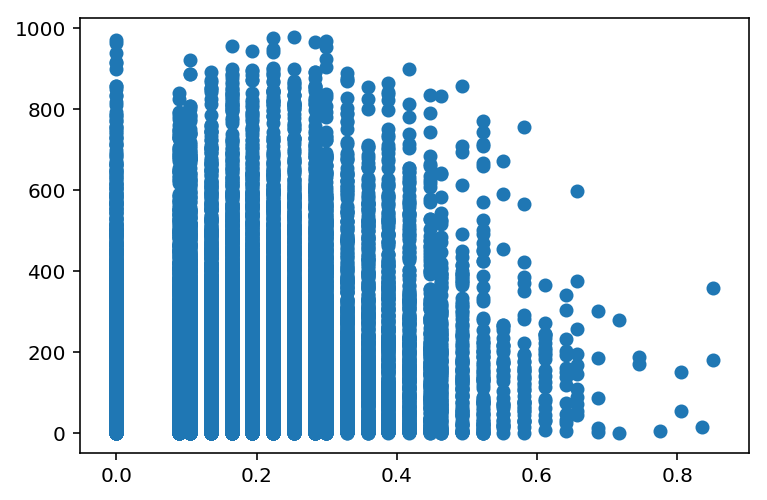

In [51]:
plt.scatter(df['windspeed'], df[out_col].values)

In [33]:
df = pd.read_csv('datasets/bikes/hour.csv')
df

feature_cols = ['workingday', 'holiday', 'temp', 'atemp', 'hum', 'windspeed']
out_col = ['cnt']
df[out_col]

,cnt
0,16
1,40
2,32
3,13
4,1
5,1
6,2
7,3
8,8
9,14


In [34]:
X = pm.floatX(df[feature_cols])
Y = pm.floatX(df[out_col].apply(np.log10))
n_hidden = X.shape[1]

with pm.Model() as nn_model:
    w1 = pm.Normal('w1', mu=0, sd=1, shape=(X.shape[1], n_hidden))
    w2 = pm.Normal('w2', mu=0, sd=1, shape=(n_hidden, 1))
    
    b1 = pm.Normal('b1', mu=0, sd=1, shape=(n_hidden,))
    b2 = pm.Normal('b2', mu=0, sd=1, shape=(1,))
    
    a1 = pm.Deterministic('a1', tt.nnet.relu(tt.dot(X, w1) + b1))
    a2 = pm.Deterministic('a2', tt.dot(a1, w2) + b2)
    
    output = pm.Normal('likelihood', mu=a2, observed=Y)

In [35]:
with pm.Model() as three_layer_model:
    w1 = pm.Normal('w1', mu=0, sd=1, shape=(X.shape[1], n_hidden))
    w2 = pm.Normal('w2', mu=0, sd=1, shape=(n_hidden, n_hidden))
    w3 = pm.Normal('w3', mu=0, sd=1, shape=(n_hidden, 1))
    
    b1 = pm.Normal('b1', mu=0, sd=1, shape=(n_hidden,))
    b2 = pm.Normal('b2', mu=0, sd=1, shape=(n_hidden,))
    b3 = pm.Normal('b3', mu=0, sd=1, shape=(1,))
    
    a1 = pm.Deterministic('a1', tt.nnet.relu(tt.dot(X, w1) + b1))
    a2 = pm.Deterministic('a2', tt.nnet.relu(tt.dot(a1, w2) + b2))
    a3 = pm.Deterministic('a3', tt.dot(a2, w3) + b3)
    
    sd = pm.HalfCauchy('sd', beta=1)
    
    output = pm.Normal('likelihood', mu=a3, sd=sd, observed=Y)

In [36]:
with pm.Model() as linreg_model:
    w1 = pm.Normal('w1', mu=0, sd=1, shape=(X.shape[1], 1))
    b1 = pm.Normal('b1', mu=0, sd=1, shape=(1,))
    a1 = pm.Deterministic('a1', tt.dot(X, w1) + b1)
    
    sd = pm.HalfCauchy('sd', beta=1)
    
    output = pm.Normal('likelihood', mu=a1, sd=sd, observed=Y)

In [37]:
with linreg_model:
    s = theano.shared(pm.floatX(1.1))
    inference = pm.ADVI(cost_part_grad_scale=s, learning_rate=.01)
    approx = pm.fit(200000, method=inference)

Average Loss = 14,604:  26%|██▋       | 52829/200000 [03:34<09:58, 245.93it/s]  
Interrupted at 52,836 [26%]: Average Loss = 19,492


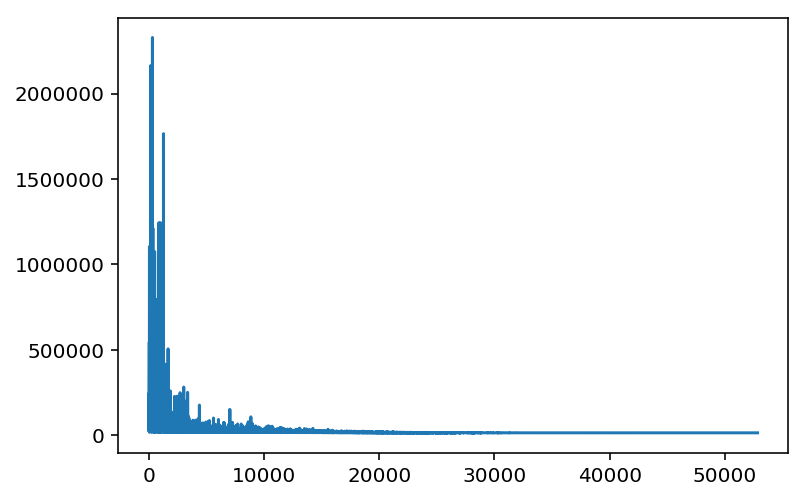

In [38]:
plt.plot(inference.hist)

In [39]:
with linreg_model:
    trace = approx.sample(2000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f631771fa90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f62e963fb38>]], dtype=object)

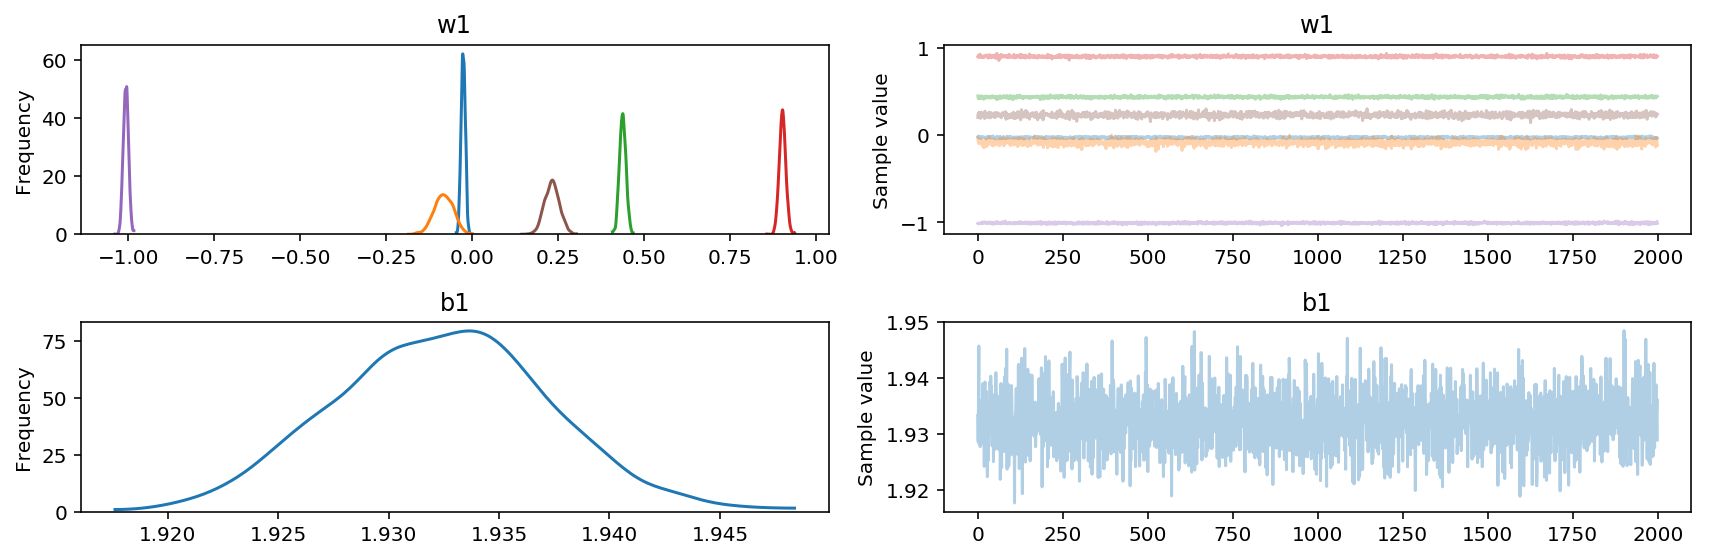

In [40]:
pm.traceplot(trace, varnames=['w1', 'b1'])

In [41]:
with linreg_model:
    samps = pm.sample_ppc(trace)

100%|██████████| 2000/2000 [00:02<00:00, 843.50it/s]


In [42]:
samps['likelihood'].std(axis=0)

array([[ 0.55180553],
       [ 0.55527453],
       [ 0.55781458],
       ..., 
       [ 0.55790702],
       [ 0.56910298],
       [ 0.5632923 ]])

In [43]:
samps['likelihood'].mean(axis=0)

array([[ 1.48673994],
       [ 1.47183858],
       [ 1.47268515],
       ..., 
       [ 1.65646867],
       [ 1.75125503],
       [ 1.6451539 ]])

In [44]:
from sklearn.metrics import mean_squared_error as mse

mse(Y, samps['likelihood'].mean(axis=0))

0.31310212038894636

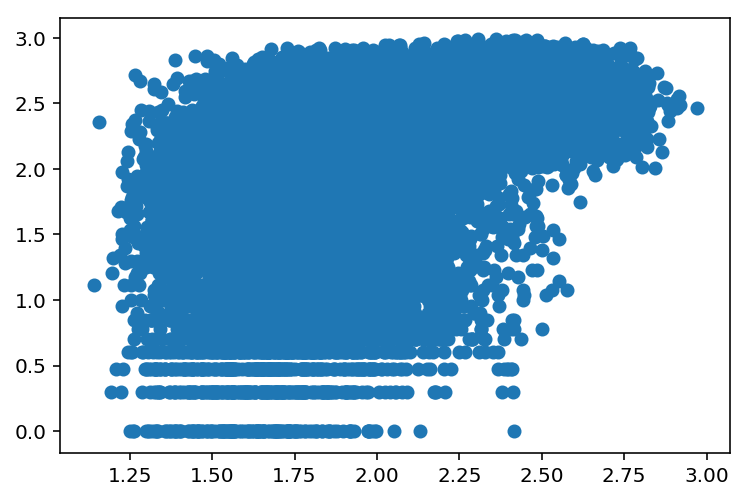

In [45]:
plt.scatter(samps['likelihood'].mean(axis=0).squeeze(), Y.values)